### Imports

In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from helpers import helpfunction as helper
from helpers import plot_class
from helpers import plot_dicts_nue
from helpers import plot_dicts_numu
import seaborn as sns
from matplotlib import colors
from matplotlib.colors import LogNorm
import gc

In [2]:
plt.rcParams.update({'axes.titlesize': 'medium'})

In [3]:
# should return resolution per bin
per1 = 50 - 45  # 68.27/2            # 1sigma stat boundaries
per2 = 50 + 45  # 68.27/2
per21 = 50 - 95.45 / 2
per22 = 50 + 95.45 / 2
persig1 = 50 - 68.27 / 2
persig2 = 50 + 68.27 / 2


def getResolution(data_x, data_y, x_edges, ax, periodic=False):
    mean = []
    err = []
    percentiles_arr = []

    mids = 0.5 * (x_edges[1:] + x_edges[:-1])
    bin_id = np.digitize(data_x, x_edges)
    data_diff = data_y - data_x  # / data_x
    if periodic:
        data_diff = (data_diff + np.pi) % (2 * np.pi) - np.pi
        data_diff *= 180 / np.pi
        mids *= 180 / np.pi
    for i in range(1, len(x_edges)):
        ax.hist(
            data_diff[bin_id == i],
            bins=50,
            range=np.percentile(data_diff, [per21, per22]),
            histtype="step",
        )
        percentiles = np.percentile(
            data_diff[bin_id == i], [per1, persig1, 50, persig2, per2]
        )
        print(
            round(10 * mids[i - 1]) / 10,
            "\t",
            np.median(data_y[bin_id == i]),
            "\t",
            percentiles[[1, 2, 3]],
            "\t",
            (percentiles[3] - percentiles[1]) / 2,
        )
        if periodic:
            percentiles /= 180 / np.pi
            mean.append(mids[i - 1] / (180 / np.pi) + percentiles[2])
        else:
            mean.append(mids[i - 1] + percentiles[2])
        err.append([percentiles[2] - percentiles[1], percentiles[3] - percentiles[2]])
        percentiles_arr.append(percentiles)
    if periodic:
        mids /= 180 / np.pi
    quants = np.array(percentiles_arr).T
    return mids, mean, err, quants


def cosmic_angles(mom_x, mom_y, mom_z):
    theta = np.arctan2(np.sqrt(np.square(mom_x) + np.square(mom_y)), mom_z)
    phi = np.arctan2(mom_y, mom_x)
    return [theta, phi]

In [4]:
input_dir = "./input/Jun2020/"
output_dir = "./output/nue/truth/"

In [5]:
title = "MicroBooNE Simulation, Preliminary"

In [6]:
mass_p = helper.mass_p

In [7]:
keys_true = [
    "nu_pdg",
    "nu_e",
    "lep_e",
    "true_nu_vtx_x",
    "true_nu_vtx_y",
    "true_nu_vtx_z",
    "nmuon",
    "nproton",
    "npi0",
    "npion",
    "nelec",
    "interaction",
    "weightSplineTimesTune",
    "n_pfps",
    "ccnc",
    "nu_completeness_from_pfp",
    "nu_purity_from_pfp",
    "event_scale",
    "nueccinc",
]

In [8]:
data = pd.read_pickle(input_dir + "after_training.pckl")

In [30]:
giuseppe = data['sideband']['daughters'].query('e_candidate & select & reco_e>1.05 & contained_fraction>0.9 & run>13000')[['run', 'sub', 'evt', 'reco_e','n_tracks_contained', 'n_showers_contained','shr_theta_v']].sort_values('run')
giuseppe.to_csv('giuseppe.txt', index=None, sep=' ', mode='a')

In [9]:
data["nu"]["mc"].keys()

dict_keys(['ccnc', 'weightSplineTimesTune', 'mc_E', 'lep_e', 'nu_pdg', 'true_nu_vtx_y', 'n_pfps', 'npion', 'npi0', 'weightSpline', 'true_nu_vtx_x', 'nelec', 'interaction', 'leeweight', 'nproton', 'nu_completeness_from_pfp', 'theta', 'nu_purity_from_pfp', 'mc_pdg', 'true_nu_vtx_z', 'nu_e', 'nmuon', 'nueccinc', 'Run', 'sample', 'filter', 'optical_filter', 'weightsFlux', 'weightsGenie', 'event_scale', 'weightSplineTimesTune_pi0scaled'])

In [10]:
highest_proton_energy = (
    (data["nu"]["mc"]["mc_pdg"] == 2212) * data["nu"]["mc"]["mc_E"]
).max()

In [11]:
nu_mc = pd.DataFrame({k: data["nu"]["mc"][k] for k in keys_true})
nu_frame = data["nu"]["daughters"]

In [12]:
del data
gc.collect()

118

In [13]:
nu_mc["true_vtx_fid"] = helper.is_fid(
    nu_mc["true_nu_vtx_x"], nu_mc["true_nu_vtx_y"], nu_mc["true_nu_vtx_z"]
)
nu_mc["max_proton_e"] = highest_proton_energy

In [14]:
q_e0p = (
    "true_vtx_fid & abs(nu_pdg)==12 & nelec>0 & nproton==0 & (npi0+npion)==0 & ccnc==0"
)
q_eNp = (
    "true_vtx_fid & abs(nu_pdg)==12 & nelec>0 & nproton>0 & (npi0+npion)==0 & ccnc==0"
)
q_eX = "true_vtx_fid & abs(nu_pdg)==12 & nelec>0 & (npi0+npion)>0 & ccnc==0"

q_m0p = (
    "true_vtx_fid & abs(nu_pdg)==14 & nmuon==1 & nproton==0 & (npi0+npion)==0 & ccnc==0"
)
q_mNp = (
    "true_vtx_fid & abs(nu_pdg)==14 & nmuon==1 & nproton>0 & (npi0+npion)==0 & ccnc==0"
)
q_mX = "true_vtx_fid & abs(nu_pdg)==14 & nmuon==1 & (npi0+npion)>0 & ccnc==0"

new_cat = (
    nu_mc.eval(q_e0p) * 1
    + nu_mc.eval(q_eNp) * 2
    + nu_mc.eval(q_eX) * 3
    + nu_mc.eval(q_m0p) * 4
    + nu_mc.eval(q_mNp) * 5
    + nu_mc.eval(q_mX) * 6
)
nu_mc["true_category"] = new_cat
nu_frame["true_category"] = np.repeat(nu_mc["true_category"], nu_mc["n_pfps"]).values

In [15]:
nu_mc["scale"] = nu_mc["weightSplineTimesTune"] * nu_mc["event_scale"]
nu_frame["scale"] = np.repeat(nu_mc["scale"], nu_mc["n_pfps"]).values

In [16]:
fields = list(nu_frame.keys())
[f for f in fields if "scale" in f]

['weightSplineTimesTune_pi0scaled', 'event_scale', 'scale']

In [17]:
# fraction of neutrino events that is nue charged current
nu_mc.query("4>true_category>0")["scale"].sum() / (
    nu_mc.query("true_vtx_fid")["scale"].sum()
) * 100

0.4819104304302329

In [18]:
cats_all = {r"$\nu_e$ CC ": [1, 2, 3], r"$\nu_\mu$ CC ": [4, 5, 6]}
c_labs = [r"0p0$\pi$", r"Np0$\pi$ (N>0)", r"NpM$\pi$ (M>0)"]
field = "nu_e"
weight = "scale"

### Plots

$\nu_e$ CC  [1, 2, 3]
1 0p0$\pi$
2 Np0$\pi$ (N>0)
3 NpM$\pi$ (M>0)
$\nu_\mu$ CC  [4, 5, 6]
4 0p0$\pi$
5 Np0$\pi$ (N>0)
6 NpM$\pi$ (M>0)
$\nu_e$ CC : 83.9%
$\nu_\mu$ CC : 83.4%


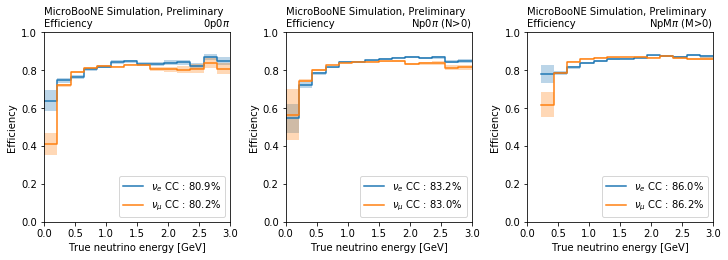

In [19]:
# Slice ID efficiecny
q_s = "n_pfps>0"
x_min = 0
x_max = 3
n_bins = 15

fig, axes = plt.subplots(ncols=3, figsize=(10, 3.5), constrained_layout=True)

for s_lab, cats in cats_all.items():
    print(s_lab, cats)
    for cat, c_lab, ax in zip(cats, c_labs, axes):
        print(cat, c_lab)
        num = nu_mc.query(q_s).query("true_category==@cat")[field]
        den = nu_mc.query("true_category==@cat")[field]
        num_w = nu_mc.query(q_s).query("true_category==@cat")[weight]
        den_w = nu_mc.query("true_category==@cat")[weight]

        eff, unc_low, unc_up, edges = plot_class.efficiency_post(
            num, den, num_w=num_w, den_w=den_w, n_bins=n_bins, x_min=x_min, x_max=x_max
        )
        ax.fill_between(edges, eff - unc_low, eff + unc_up, alpha=0.3, step="post")
        ax.step(
            edges,
            eff,
            where="post",
            label="{0}: {1:.1%}".format(s_lab, sum(num_w) / sum(den_w)),
        )
        ax.set_title(c_lab, loc="right")
        ax.set_title(title+"\nEfficiency", loc="left")
        ax.set_xlabel("True neutrino energy [GeV]")
        ax.set_ylabel("Efficiency")
        ax.set_ylim(0, 1)
        ax.set_xlim(x_min, x_max)
        ax.legend(loc="lower right")

fig.savefig(output_dir + "sliceID_eff.pdf", bbox_inches="tight")

# Overall performance
for s_lab, cats in cats_all.items():
    print(
        "{0}: {1:.1%}".format(
            s_lab,
            sum(nu_mc.query("true_category in @cats").query(q_s)[weight])
            / sum(nu_mc.query("true_category in @cats")[weight]),
        )
    )

In [20]:
electrons = nu_frame.query(
    "4>true_category>0 & abs(backtracked_pdg)==11 & e_candidate & preselect"
)
photons = nu_frame.query(
    "true_category>3 & abs(backtracked_pdg)==22 & e_candidate & preselect"
)

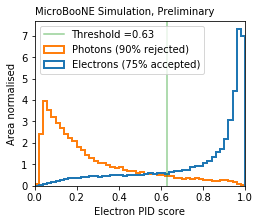

In [21]:
cut = 0.63
e_pass = electrons.query("score>@cut")[weight].sum() / electrons[weight].sum()
g_pass = photons.query("score>@cut")[weight].sum() / photons[weight].sum()

fig, ax = plt.subplots(figsize=(3.5, 3), constrained_layout=True)

ax.axvline(x=cut, label="Threshold =" + str(cut), color="C2", alpha=0.5)
ax.hist(
    [electrons["score"], photons["score"]],
    label=[
        "Electrons ({:.0%} accepted)".format(e_pass),
        "Photons ({:.0%} rejected)".format(1 - g_pass),
    ],
    range=(0, 1),
    bins=50,
    histtype="step",
    lw=2,
    normed=True,
)
ax.legend(loc="upper left")
ax.set_title(title, loc="left")
ax.set_xlabel("Electron PID score")
ax.set_ylabel("Area normalised")
ax.set_xlim(0, 1)

fig.savefig(output_dir + "e_gamma_sep.pdf", bbox_inches="tight")

In [22]:
# Everything below here is electron neutrino specific

In [23]:
nue_mc = nu_mc.query("nueccinc")
nue_frame = nu_frame.query("nueccinc")

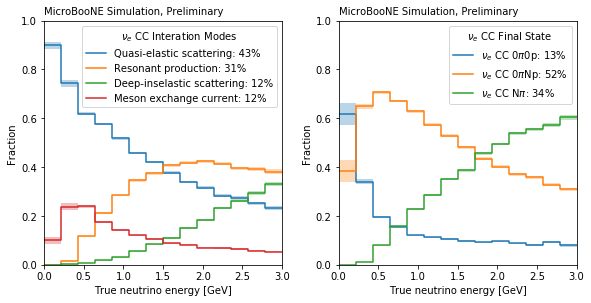

In [24]:
x_min = 0
x_max = 3
n_bins = 15

fig, axes = plt.subplots(ncols=2, figsize=(8.1, 4.1), constrained_layout=True, sharex=True)

axes = axes[::-1]
sel_field = ["true_category", "interaction"]
cats_arr = [{1: 10, 2: 11, 3: 1}, {0: 0, 1: 1, 2: 2, 10: 10}]
lab_dict = [plot_dicts_nue.category_labels, plot_dicts_nue.int_labels]
titles = ["Final State", "Interation Modes"]

for ax, cats, sel, lab_d, leg_t in zip(axes, cats_arr, sel_field, lab_dict, titles):
    for cat, cat_d in cats.items():
        den = nue_mc[field]
        num = nue_mc[field][nue_mc[sel] == cat]

        den_w = nue_mc[weight]
        num_w = nue_mc[weight][nue_mc[sel] == cat]

        eff, unc_low, unc_up, edges = plot_class.efficiency_post(
            num, den, num_w=num_w, den_w=den_w, n_bins=n_bins, x_min=x_min, x_max=x_max
        )
        ax.fill_between(edges, eff - unc_low, eff + unc_up, alpha=0.3, step="post")
        ax.step(
            edges,
            eff,
            where="post",
            label="{0}: {1:.0f}%".format(lab_d[cat_d], sum(num_w) / sum(den_w) * 100),
        )
    ax.set_title(title, loc="left")
    ax.set_xlabel("True neutrino energy [GeV]")
    ax.set_ylabel("Fraction")
    ax.set_ylim(0, 1)
    ax.set_xlim(x_min, x_max)
    ax.legend(loc="upper right", title=r"$\nu_e$ CC " + leg_t)

fig.savefig(output_dir + "truth_channels_modes.pdf", bbox_inches="tight")

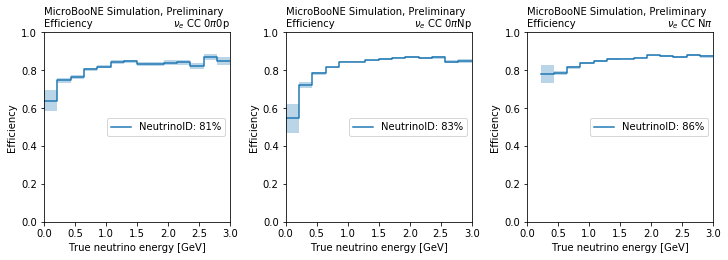

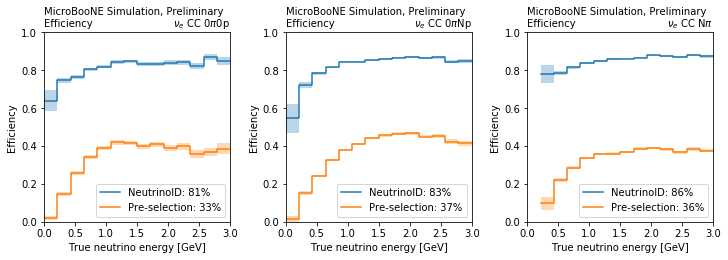

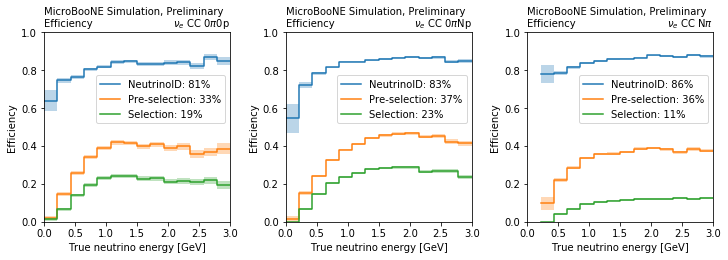

In [25]:
# eff per cat
cats = {1: 10, 2: 11, 3: 1}
x_min = 0
x_max = 3
n_bins = 15
selectors = ["daughter==0", "e_candidate & preselect", "e_candidate & select"]
labs = ["NeutrinoID", "Pre-selection", "Selection"]

for i in range(3):
    fig, axes = plt.subplots(ncols=3, figsize=(10, 3.5), constrained_layout=True)

    for cat, ax in zip(cats.keys(), axes):
        for selector, lab in zip(selectors[: (i + 1)], labs):
            num = nue_frame.query(selector).query("true_category==@cat")[field]
            den = nue_mc[field][nue_mc["true_category"] == cat]

            num_w = nue_frame.query(selector).query("true_category==@cat")[weight]
            den_w = nue_mc[weight][nue_mc["true_category"] == cat]

            eff, unc_low, unc_up, edges = plot_class.efficiency_post(
                num,
                den,
                num_w=num_w,
                den_w=den_w,
                n_bins=n_bins,
                x_min=x_min,
                x_max=x_max,
            )
            ax.fill_between(edges, eff - unc_low, eff + unc_up, alpha=0.3, step="post")
            ax.step(
                edges,
                eff,
                where="post",
                label="{}: {:.0%}".format(lab, sum(num_w) / sum(den_w)),
            )
        ax.set_title(title + "\nEfficiency", loc="left")
        ax.set_title(plot_dicts_nue.category_labels[cats[cat]], loc="right")
        ax.set_xlabel("True neutrino energy [GeV]")
        ax.set_ylabel("Efficiency")
        ax.set_ylim(0, 1)
        ax.set_xlim(x_min, x_max)
        if i == 0:
            ax.legend(loc="center right")
        elif i == 1:
            ax.legend(loc="lower right")
        else:
            ax.legend(loc="upper right", bbox_to_anchor=(1, 0.8))
    fig.savefig(output_dir + "efficiency_cat_{}.pdf".format(i), bbox_inches="tight")

NeutrinoID: 83.9%+-0.1%
Pre-selection: 83.9%+-0.1%
Pre-selection: 36.1%+-0.2%
Selection: 83.9%+-0.1%
Selection: 36.1%+-0.2%
Selection: 18.0%+-0.1%


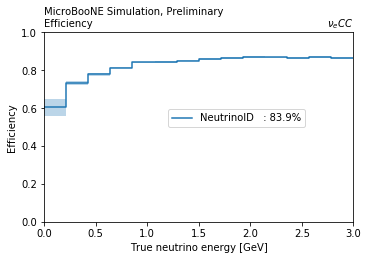

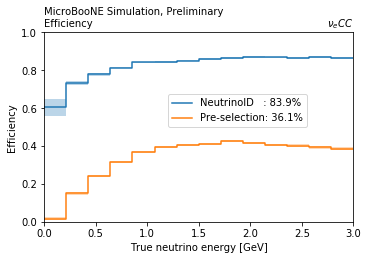

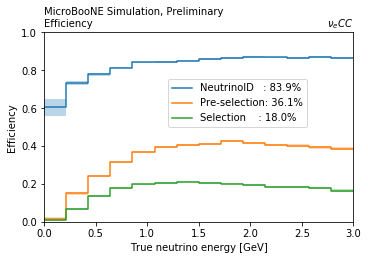

In [26]:
# eff total
x_min = 0
x_max = 3
n_bins = 15
selectors = ["daughter==0", "e_candidate & preselect", "e_candidate & select"]
labs = ["NeutrinoID", "Pre-selection", "Selection"]


for i in range(3):
    fig, ax = plt.subplots(ncols=1, figsize=(5, 3.5), constrained_layout=True)

    for selector, lab in zip(selectors[: (i + 1)], labs):
        num = nue_frame.query(selector)[field]
        den = nue_mc[field]

        num_w = nue_frame.query(selector)[weight]
        den_w = nue_mc[weight]
        
        print('{}: {:.1%}+-{:.1%}'.format(labs[i],*helper.effErr(num_w, den_w)))

        eff, unc_low, unc_up, edges = plot_class.efficiency_post(
            num, den, num_w=num_w, den_w=den_w, n_bins=n_bins, x_min=x_min, x_max=x_max
        )
        ax.fill_between(edges, eff - unc_low, eff + unc_up, alpha=0.3, step="post")
        ax.step(
            edges,
            eff,
            where="post",
            label="{0:<13}: {1:0.1%}".format(lab, sum(num_w) / sum(den_w)),
        )
    ax.set_title(r"$\nu_e CC$", loc="right")
    ax.set_title(title + "\nEfficiency", loc="left")
    ax.set_xlabel("True neutrino energy [GeV]")
    ax.set_ylabel("Efficiency")
    ax.set_ylim(0, 1)
    ax.set_xlim(x_min, x_max)
    ax.legend(loc=(0.4,0.5))

    fig.savefig(output_dir + "efficiency_{}.pdf".format(i), bbox_inches="tight")

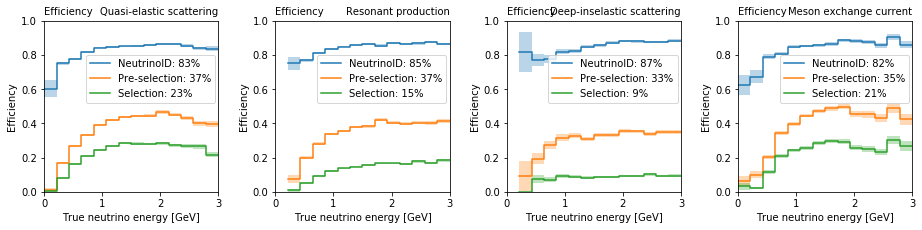

In [27]:
# eff per mode
cats = [0, 1, 2, 10]
fig, axes = plt.subplots(ncols=4, figsize=(13, 3.3))

for cat, ax in zip(cats, axes):
    for selector, lab in zip(selectors, labs):
        num = nue_frame.query(selector).query("interaction==@cat & true_category>0")[
            field
        ]
        den = nue_mc[field][
            (nue_mc["interaction"] == cat) & (nue_mc["true_category"] > 0)
        ]

        num_w = nue_frame.query(selector).query("interaction==@cat & true_category>0")[
            weight
        ]
        den_w = nue_mc[weight][
            (nue_mc["interaction"] == cat) & (nue_mc["true_category"] > 0)
        ]

        eff, unc_low, unc_up, edges = plot_class.efficiency_post(
            num, den, num_w=num_w, den_w=den_w, n_bins=n_bins, x_min=x_min, x_max=x_max
        )
        ax.fill_between(edges, eff - unc_low, eff + unc_up, alpha=0.3, step="post")
        ax.step(
            edges,
            eff,
            where="post",
            label="{}: {:.0f}%".format(lab, sum(num_w) / sum(den_w) * 100),
        )
    ax.set_title(plot_dicts_nue.int_labels[cat], loc="right")
    ax.set_title("Efficiency", loc="left")
    ax.set_xlabel("True neutrino energy [GeV]")
    ax.set_ylabel("Efficiency")
    ax.set_ylim(0, 1)
    ax.set_xlim(x_min, x_max)
    ax.legend(loc=(0.24,0.522))

fig.tight_layout()
fig.savefig(output_dir + "efficiency_int.pdf", bbox_inches="tight")

In [28]:
daughters = nue_frame.query("e_candidate & preselect").query(
    "abs(backtracked_pdg)==11 & true_category>0 "
)

cols = ["backtracked_px", "backtracked_py", "backtracked_pz"]
daughters["backtracked_theta"], daughters["backtracked_phi"] = cosmic_angles(
    *daughters[cols].T.values
)

In [29]:
daughters["shr_energy_y_v"].describe()

count    53511.000000
mean       927.890686
std        594.133606
min        100.025894
25%        485.805817
50%        796.799377
75%       1218.623474
max       4953.538574
Name: shr_energy_y_v, dtype: float64

In [30]:
daughters["e_reco_y"] = daughters["shr_energy_y_v"] / 1000
daughters = daughters.clip(-4, 300)

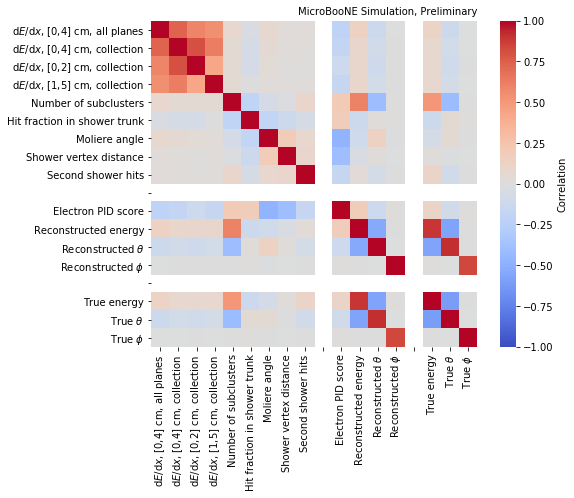

In [31]:
columns_map = [
    "shr_tkfit_4cm_dedx_wm_v",
    "shr_tkfit_dedx_y_v",
    "shr_tkfit_2cm_dedx_Y",
    "shr_tkfit_gap10_dedx_y_v",
    "shr_subclusters_v",
    "shr_tkfit_hitratio_v",
    "shr_moliere_avg_v",
    "shr_dist_v",
    "secondshower_Y_nhit",
    "",
    "score",
    "e_reco_y",
    "shr_theta_v",
    "shr_phi_v",
    "",
    "backtracked_e",
    "backtracked_theta",
    "backtracked_phi",
]

map_labels = [
    r"d$E/$d$x$, [0,4] cm, all planes",
    r"d$E/$d$x$, [0,4] cm, collection",
    r"d$E/$d$x$, [0,2] cm, collection",
    r"d$E/$d$x$, [1,5] cm, collection",
    "Number of subclusters",
    "Hit fraction in shower trunk",
    "Moliere angle",
    "Shower vertex distance",
    "Second shower hits",
    "",
    "Electron PID score",
    "Reconstructed energy",
    r"Reconstructed $\theta$",
    r"Reconstructed $\phi$",
    "",
    "True energy",
    r"True $\theta$",
    r"True $\phi$",
]

daughters[""] = 0

plt.subplots(figsize=(8, 6))
sns.heatmap(
    daughters[columns_map].corr(),
    cmap="coolwarm",
    xticklabels=map_labels,
    yticklabels=map_labels,
    vmin=-1,
    vmax=1,
    cbar_kws={"label": "Correlation"},
    square=True,
)
plt.title(title, loc="right")
plt.savefig(output_dir + "e_cand_corr.pdf", bbox_inches="tight")


Energy
0.1 	 0.15162982 	 [0.00208226 0.02236533 0.09506637] 	 0.04649205909222364
0.2 	 0.21528478 	 [-0.04229064  0.01013143  0.0563626 ] 	 0.0493266179524362
0.3 	 0.2949596 	 [-0.08641948 -0.00265411  0.05165866] 	 0.06903906857967376
0.4 	 0.38437733 	 [-0.12140276 -0.01153058  0.05624316] 	 0.08882296229749916
0.5 	 0.472243 	 [-0.16391812 -0.02484873  0.06112602] 	 0.11252207420542834
0.6 	 0.5646868 	 [-0.19912561 -0.03496405  0.0691001 ] 	 0.134112852474302
0.7 	 0.65549695 	 [-0.2327363  -0.04201472  0.075196  ] 	 0.1539661506704986
0.8 	 0.7483746 	 [-0.26344889 -0.05119032  0.0782781 ] 	 0.17086349478363988
0.9 	 0.8271148 	 [-0.30482663 -0.06762376  0.07149606] 	 0.18816134125739337
1.0 	 0.924772 	 [-0.33337218 -0.07384753  0.07832843] 	 0.20585030388832093
1.1 	 1.0023445 	 [-0.36108788 -0.09126216  0.07348309] 	 0.21728548336923115
1.2 	 1.0903366 	 [-0.39830546 -0.10366726  0.07121723] 	 0.2347613408476114
1.3 	 1.17465 	 [-0.44685714 -0.12486929  0.07240502] 	 0.2596

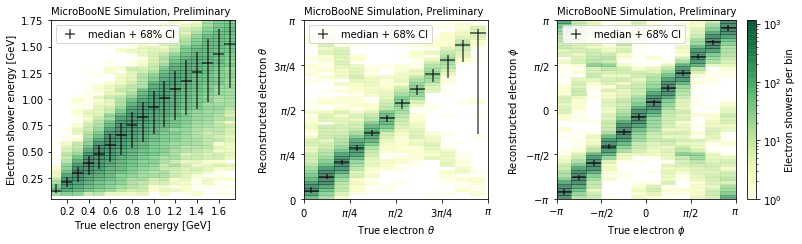

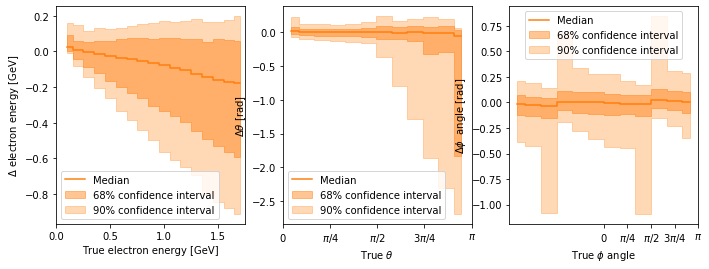

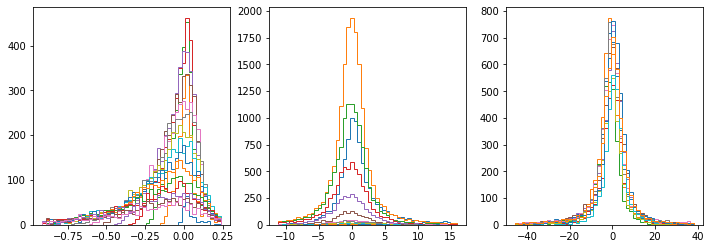

In [32]:
fig, ax = plt.subplots(
    ncols=3, figsize=(11.2, 3.5), gridspec_kw={"width_ratios": [4, 4, 4.85]}
)

fig_res, ax_res = plt.subplots(ncols=3, figsize=(11.5, 4))
fig2, ax2 = plt.subplots(ncols=3, figsize=(12, 4))
n_x = 17
n_y = 50

print("\nEnergy")
y_min = 0.05
y_max = 1.75
fld_mc = "backtracked_e"
fld_reco = "e_reco_y"
h, x_edges, y_edges, im = ax[0].hist2d(
    daughters.eval(fld_mc),
    daughters.eval(fld_reco),
    cmap="YlGn",
    bins=(n_x, n_y),
    alpha=0.65,
    norm=colors.LogNorm(),
    range=((y_min, y_max), (y_min, y_max)),
)
ax[0].set_xlabel("True electron energy [GeV]")
ax[0].set_ylabel("Electron shower energy [GeV]")
mids, mean, err, quants = getResolution(
    daughters.eval(fld_mc), daughters.eval(fld_reco), x_edges, ax2[0]
)
ax[0].set_xticks([0.2, 0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6])
ax[0].errorbar(
    mids,
    mean,
    xerr=(mids[0] - x_edges[0]),
    yerr=np.array(err).T,
    color="k",
    fmt="none",
    label=r"median + 68% CI",
    alpha=0.7,
)
ax[0].legend(loc="upper left")
ax[0].set_title(title, loc="left")

ax_res[0].step(mids, quants[2], lw=1.5, label="Median", where="mid", color="C1")
ax_res[0].fill_between(
    mids,
    quants[1],
    quants[3],
    alpha=0.45,
    step="mid",
    color="C1",
    label="68% confidence interval",
)
ax_res[0].fill_between(
    mids,
    quants[0],
    quants[4],
    alpha=0.3,
    step="mid",
    color="C1",
    label="90% confidence interval",
)
ax_res[0].set_xlabel("True electron energy [GeV]")
ax_res[0].set_ylabel(r"$\Delta$ electron energy [GeV]")
ax_res[0].set_xlim(0, y_max)
ax_res[0].legend()

print("\nTheta")
n_x = 12
fld_mc, fld_reco = "backtracked_theta", "shr_theta_v"
h, x_edges, y_edges, im = ax[1].hist2d(
    daughters[fld_mc],
    daughters[fld_reco],
    cmap="YlGn",
    bins=(n_x, n_y),
    alpha=0.65,
    norm=colors.LogNorm(),
)
ax[1].set_xticks(helper.theta_ticks)
ax[1].set_xticklabels(helper.theta_labs)
ax[1].set_yticks(helper.theta_ticks)
ax[1].set_yticklabels(helper.theta_labs)
ax[1].set_xlabel(r"True electron $\theta$")
ax[1].set_ylabel(r"Reconstructed electron $\theta$")
ax[1].set_ylim(0, np.pi)
ax[1].set_title(title, loc="left")
mids, mean, err, quants = getResolution(
    daughters[fld_mc], daughters[fld_reco], x_edges, ax2[1], periodic=True
)
ax[1].errorbar(
    mids,
    mean,
    xerr=(mids[0] - x_edges[0]),
    yerr=np.array(err).T,
    color="k",
    fmt="none",
    label=r"median + 68% CI",
    alpha=0.7,
)
ax[1].legend(loc="upper left")


ax_res[1].step(mids, quants[2], lw=1.5, label="Median", where="mid", color="C1")
ax_res[1].fill_between(
    mids,
    quants[1],
    quants[3],
    alpha=0.45,
    step="mid",
    color="C1",
    label="68% confidence interval",
)
ax_res[1].fill_between(
    mids,
    quants[0],
    quants[4],
    alpha=0.3,
    step="mid",
    color="C1",
    label="90% confidence interval",
)
ax_res[1].set_xticks(helper.theta_ticks)
ax_res[1].set_xticklabels(helper.theta_labs)
ax_res[1].set_xlabel(r"True $\theta$")
ax_res[1].set_ylabel(r"$\Delta \theta$ [rad]")
ax_res[1].set_xlim(0, np.pi)
ax_res[1].legend()

print("\nPhi")
n_x = 12
fld_mc, fld_reco = "backtracked_phi", "shr_phi_v"
h, x_edges, y_edges, im = ax[2].hist2d(
    daughters[fld_mc],
    daughters[fld_reco],
    cmap="YlGn",
    bins=(n_x, n_y),
    alpha=0.65,
    norm=colors.LogNorm(),
)
ax[2].set_xticks(helper.phi_ticks)
ax[2].set_xticklabels(helper.phi_labs)
ax[2].set_yticks(helper.phi_ticks)
ax[2].set_yticklabels(helper.phi_labs)
ax[2].set_xlabel(r"True electron $\phi$")
ax[2].set_ylabel(r"Reconstructed electron $\phi$")
ax[2].set_ylim(-np.pi, np.pi)
mids, mean, err, quants = getResolution(
    daughters[fld_mc], daughters[fld_reco], x_edges, ax2[2], periodic=True
)
ax[2].errorbar(
    mids,
    mean,
    xerr=(mids[0] - x_edges[0]),
    yerr=np.array(err).T,
    color="k",
    fmt="none",
    label=r"median + 68% CI",
    alpha=0.7,
)
ax[2].legend(loc="upper left")
ax[2].set_title(title, loc="left")

ax_res[2].step(mids, quants[2], lw=1.5, label="Median", where="mid", color="C1")
ax_res[2].fill_between(
    mids,
    quants[1],
    quants[3],
    alpha=0.45,
    step="mid",
    color="C1",
    label="68% confidence interval",
)
ax_res[2].fill_between(
    mids,
    quants[0],
    quants[4],
    alpha=0.3,
    step="mid",
    color="C1",
    label="90% confidence interval",
)
ax_res[2].set_xticks(helper.theta_ticks)
ax_res[2].set_xticklabels(helper.theta_labs)
ax_res[2].set_xlabel(r"True $\phi$ angle")
ax_res[2].set_ylabel(r"$\Delta \phi$  angle [rad]")
ax_res[2].set_xlim(-np.pi, np.pi)
ax_res[2].legend(loc="upper center")


#[ax_i.set_aspect("equal") for ax_i in ax]

clb = fig.colorbar(im, ax=ax[2])
clb.set_label("Electron showers per bin", rotation=90)
fig.tight_layout()
fig.savefig(output_dir + "electron_resolution.pdf")

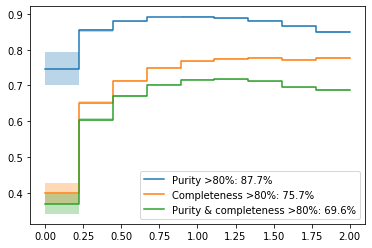

In [33]:
fig, ax = plt.subplots()

x_min = 0
x_max = 2.0
n_bins = 10

q_arr = [
    "nu_purity_from_pfp>0.8",
    "nu_completeness_from_pfp>0.8",
    "(nu_purity_from_pfp>0.8)*(nu_completeness_from_pfp>0.8)",
]
lab_arr = ["Purity >80%", "Completeness >80%", "Purity & completeness >80%"]
q_den = nu_mc.query("(true_category>0)*(n_pfps>0)")
nu_e_dv = q_den["nu_e"]
nu_e_dw = q_den[weight]
for q, l in zip(q_arr, lab_arr):
    nu_e_q = q_den.query(q)["nu_e"]
    w_q = q_den.query(q)[weight]

    eff, unc_low, unc_up, edges = plot_class.efficiency_post(
        nu_e_q,
        nu_e_dv,
        num_w=w_q,
        den_w=nu_e_dw,
        n_bins=n_bins,
        x_min=x_min,
        x_max=x_max,
    )

    ax.fill_between(edges, eff - unc_low, eff + unc_up, alpha=0.3, step="post")
    ax.step(
        edges,
        eff,
        where="post",
        label="{0}: {1:.1%}".format(l, sum(w_q) / sum(nu_e_dw)),
    )
ax.legend()